In [96]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict
import os

In [97]:
# Load environment variables
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [98]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

In [99]:
def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

In [100]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [101]:
def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [102]:
from typing import Optional
from langchain_core.runnables import RunnableLambda

In [8]:
class State(TypedDict):
    topic: str
    author: str
    question: str
    combined_index: Optional[FAISS]
    objective_check: bool
    response_summary:bool
    validate_response: str
    fact_correction:str
    generate_final_response: str

In [122]:
def get_topic_details(state=None) -> State:
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "",
        "combined_index": None,
        "objective_check": "",
        "response_summary":"",
        "validate_response": "",
        "fact_correction":"",
        "generate_final_response": ""
    }

In [123]:
def get_user_question(state: State) -> State:
    return {
        **state,
        "question": "current economic condition what is the best investment?"
    }

In [124]:
def process_youtube_items(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if result.transcript:
            full_text = f"Video: {result.title}\nTranscript: {result.transcript}"
            chunks = text_splitter.split_text(full_text)
            documents.extend([
                Document(
                    page_content=chunk,
                    metadata={
                        "source": "youtube",
                        "video_id": result.video_id,
                        "title": result.title
                    }
                ) for chunk in chunks
            ])
    return documents

In [106]:
def process_ddg_results(results):
    return [
        Document(
            page_content=result,
            metadata={
                "source": "web",
                "search_query": state["topic"] + " " + state["author"]
            }
        ) for result in results.split("\n\n") if result.strip()
    ]

In [107]:
def build_combined_index(state: State) -> State:
    try:
        print("\n=== Building Combined Knowledge Base ===")
        
        # 1. Get YouTube data
        yt_items = search_yt(f"{state['topic']} {state['author']}")
        yt_docs = process_youtube_items(yt_items)
        
        # 2. Get DuckDuckGo data
        ddg_results = DuckDuckGoSearchRun().invoke(
            f"{state['topic']} {state['author']} recent articles/interviews"
        )
        ddg_docs = process_ddg_results(ddg_results)
        
        # 3. Combine and index
        all_docs = yt_docs + ddg_docs
        if not all_docs:
            raise ValueError("No documents found from any source")
            
        state["combined_index"] = FAISS.from_documents(all_docs, embedder)
        print(f"✅ Created combined index with {len(all_docs)} documents")
        return state
        
    except Exception as e:
        print(f"Index build error: {str(e)}")
        return state

In [108]:
def generate_author_response(state: State) -> State:
    try:
        print("\n=== Generating Author-Style Response ===")
        print("question", state["question"])
        
        template = """As {author}'s analytical clone specializing in {topic}, my perspective is:

        Context: {context}
        
        Question: {question}
        
        Requirements:
        1. Maintain {author}'s signature style
        2. Integrate both historical and current insights
        3. Highlight practical applications
        4. Acknowledge limitations where applicable
        
        Analysis:"""
        
        prompt = ChatPromptTemplate.from_template(template)
        
        rag_chain = (
            {
            "context": state["combined_index"].as_retriever(search_kwargs={"k": 5}),
            "question": RunnablePassthrough(),
            "author": lambda _: state["author"],
            "topic": lambda _: state["topic"]        
            }
            | prompt
            | llm
            | StrOutputParser()
        )

        
        state["response_summary"] = rag_chain.invoke(state["question"])
        
        print("response_summary", state["response_summary"])

        return state
        
    except Exception as e:
        print(f"Generation error: {str(e)}")
        state["response_summary"] = "Error generating response"
        return state

In [109]:
def validate_user_input(state: State):
    validation_prompt = f"""**Relevance Validation Task**
    
    Author: {state['author']}
    Topic: {state['topic']}
    Question: {state['question']}

    **Rules:**
    1. Focus on financial/economic concepts for "Rich Dad Poor Dad" topics
    2. Consider {state['author']}'s known expertise
    3. Allow tangential but related concepts (e.g., assets, investments, cash flow)
    4. Reject completely unrelated topics (e.g., romance, sports, politics)

    **Examples:**
    - Topic: Assets | Question: "Is a house an asset?" → True
    - Topic: Investing | Question: "Best stocks in 2024?" → True  
    - Topic: Cash Flow | Question: "How to find true love?" → False

    **Decision:**
    Respond ONLY with 'True' or 'False'"""

    print(f"Validating: '{state['question']}' against topic: '{state['topic']}'")

    response = llm.invoke(validation_prompt).content.strip().lower()
    is_valid = response == "true"
        
    print(f"Validation result: {is_valid} | Raw response: '{response}'")
    return {"objective_check": is_valid}

In [110]:
import re 

def validate_facts(state: State):
    print(f"\n=== Validating YouTube Summary for '{state['question']}' ===")
        
    feedback_prompt = f"""**Validation Task: Summary Quality Check**

    [Author] {state['author']}
    [Topic] {state['topic']}
    [User Question] {state['question']}

    [Quality Criteria]
    1. Directly answers the specific question asked
    2. Uses {state['author']}'s signature communication style
    3. Contains concrete examples/data from source material
    4. Acknowledges limitations when information is missing

    [Summary to Validate]
    {state['response_summary']}

    [Validation Rules]
    - Respond "VALID" if all criteria are met
    - Respond "SEARCH FOR CONTENT: [Topic Area] - [Author] - [Specific Need]" if:
        * Missing key question aspects
        * Contains generic/non-specific information
        * Lacks author-style analysis

    [Examples]
    Good Response: VALID
    Needs Improvement: SEARCH FOR CONTENT: real estate investing - Robert Kiyosaki - 2024 market trends"""

    response = llm.invoke(feedback_prompt).content.strip()
    print(f"Raw validation response: {response}")

    # Process response
    if "VALID" in response.upper():
        state["validate_response"] = "VALID"
    else:
        # Extract and clean search terms
        search_terms = re.search(r"SEARCH FOR CONTENT: (.+)", response, re.IGNORECASE)
        clean_terms = re.sub(r'[^a-zA-Z0-9\s\-,:]', '', search_terms.group(1))
        state["validate_response"] = f"SEARCH FOR CONTENT: {clean_terms}"

    return state

In [111]:
def fact_checks(state: State):
    search = DuckDuckGoSearchRun()
    search_query = ""

    # Determine search terms
    if "SEARCH:" in state["validate_response"]:
        # Extract specific search terms
        search_terms = state["validate_response"].split("SEARCH:")[-1].strip()
        search_query = f"{state['author']} {search_terms}"
        print(f"🔍 Using validation feedback terms: {search_terms}")

    # Execute search
    results = search.invoke(search_query)
    
    # Store results with fallback
    state["fact_correction"] = results[:1000] if results else "No additional information found"
    
    return state

In [112]:
def consolidate_summary(state: State) -> State:
    """Generate final summary combining verified sources with error handling"""
    try:
        # Handle failed objective check
        if not state.get("objective_check", True):
            state["generate_summary"] = "❌ Question not relevant to the topic"
            return state

        # Determine context sources
        primary_analysis = state.get("response_summary", "")
        needs_verification = "VALID" not in state.get("validate_response", "").upper()
        external_data = state.get("fact_correction", "") if needs_verification else ""

        # Build context string conditionally
        context_sources = f"[Primary Analysis]\n{primary_analysis}"
        if external_data and "No additional information" not in external_data:
            context_sources += f"\n\n[External Verification]\n{external_data}"

        # Create dynamic prompt
        prompt = f"""As {state['author']}'s analytical clone, synthesize this response:

        {context_sources}

        [User Question] {state['question']}

        Requirements:
        1. {"Acknowledge information limits" if needs_verification else "Provide definitive analysis"}
        2. Maintain {state['author']}'s signature style
        3. Focus on practical {state['topic']} applications
        4. {"Highlight verified external data" if external_data else ""}
        5. Keep under 500 words

        Structured Analysis:"""
        
        state["generate_summary"] = llm.invoke(prompt).content
        return state

    except Exception as e:
        print(f"Consolidation error: {str(e)}")
        state["generate_summary"] = "Error generating final analysis"
        return state

In [113]:
# Initialize
state = get_topic_details()

# Build knowledge base
state = build_combined_index(state)

# Get question
state = get_user_question(state)

# Generate response
state = generate_author_response(state)

print(f"\nFinal Analysis:\n{state['response_summary']}")


=== Building Combined Knowledge Base ===
✅ Created combined index with 411 documents

=== Generating Author-Style Response ===
question current economic condition what is the best investment?
response_summary In the current economic condition, the best investment may not be the most obvious one. As Robert Kiyosaki often emphasizes, it is essential to look beyond traditional advice and think outside the box to seize opportunities for significant growth.

Reflecting on historical insights, we can see that during times of economic downturn, such as the early 1990s in Phoenix, Arizona, when the stock market was booming, and real estate prices were depressed, astute investors like Kiyosaki took advantage of the situation. They were not swayed by the crowd mentality but rather looked for undervalued assets with the potential for substantial returns.

Today, amidst fluctuations in the market and uncertainties in the global economy, it is crucial to remain true to oneself and avoid following 

In [114]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [115]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validate_summary = state.get("validate_response", "")

    if validate_summary == "Valid":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validate_summary
    print("need more info")
    return "need more info"

In [116]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [117]:
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_topic", get_topic_details)
Graphbuilder.add_node("content_prep",build_combined_index)
Graphbuilder.add_node("get_user_question", get_user_question)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("generate_author_response", generate_author_response)
Graphbuilder.add_node("validate_author_response", validate_facts)
Graphbuilder.add_node("additional_facts", fact_checks)
Graphbuilder.add_node("consolidate_author_response", consolidate_summary)


Graphbuilder.add_edge(START, "get_topic")
Graphbuilder.add_edge("get_topic", "content_prep")
Graphbuilder.add_edge("content_prep", "get_user_question")
Graphbuilder.add_edge("get_user_question", "validate_user_input")
Graphbuilder.add_edge("generate_author_response", "validate_author_response")
Graphbuilder.add_edge("additional_facts", "consolidate_author_response")
Graphbuilder.add_edge("consolidate_author_response", END)



Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "generate_author_response",
        "Rejected": "consolidate_author_response"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_author_response",
    route_basedon_Summary,
    {
        "Accepted": "consolidate_author_response",
        "need more info": "additional_facts"
    }
)


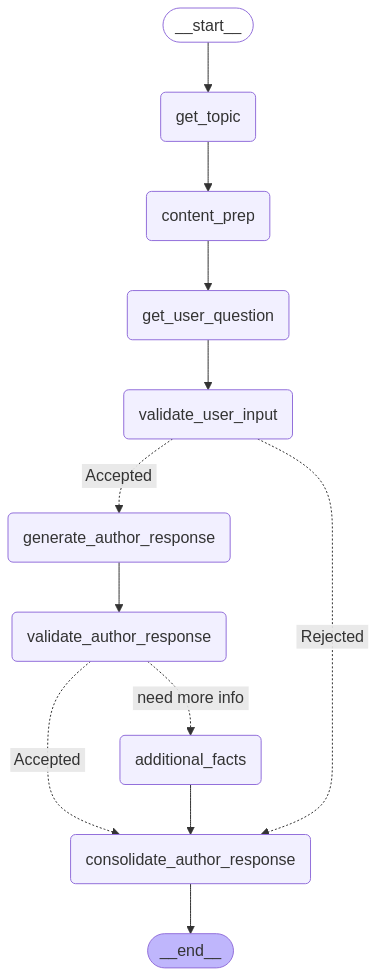

In [126]:
workflow = Graphbuilder.compile()
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [125]:
def get_topic_details(state=None) -> State:
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "",
        "combined_index": None,
        "objective_check": "",
        "response_summary":"",
        "validate_response": "",
        "fact_correction":"",
        "generate_final_response": ""
    }
def get_user_question(state: State) -> State:
    return {
        "question": "current economic condition what is the best investment?"
    }

In [128]:
state = generate_author_response(state)

print(f"\nFinal Analysis:\n{state['response_summary']}")


=== Generating Author-Style Response ===
question current economic condition what is the best investment?
Generation error: 'combined_index'

Final Analysis:
Error generating response


In [127]:
workflow = Graphbuilder.compile()
state = get_topic_details({})
state = get_user_question({})
final_State = workflow.invoke(state)
print("Final State: ", final_State)


=== Building Combined Knowledge Base ===
Index build error: 'topic'
Validating: 'current economic condition what is the best investment?' against topic: 'Rich Dad Poor Dad'
Validation result: True | Raw response: 'true'
Accepted

=== Generating Author-Style Response ===
question current economic condition what is the best investment?
Generation error: 'list' object has no attribute 'as_retriever'

=== Validating YouTube Summary for 'current economic condition what is the best investment?' ===
Raw validation response: SEARCH FOR CONTENT: current economic conditions - Robert Kiyosaki - best investments for 2021
need more info


DuckDuckGoSearchException: keywords is mandatory